# **DNN per selezionare i jet VBF**

## Importa le librerie matematiche

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch import optim
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install umap-learn
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
!pip install shap
import shap
from itertools import combinations

## Download dei dati e costruzione del dataset

In [ ]:
# monta Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
directory_sig = "/content/gdrive/My Drive/Colab Notebooks/Progetto CERN/Dati_VBF/Segnale/"
directory_bkg = "/content/gdrive/My Drive/Colab Notebooks/Progetto CERN/Dati_VBF/Fondo/"

# list of all .h5 files in the folder
h5_files_sig = [os.path.join(directory_sig, f) for f in os.listdir(directory_sig) if f.endswith('.h5')]
print(f"Found {len(h5_files_sig)} signal files")

# reads all signal files and creates the related dataset
df_list = []
count_sig = 0
for f in h5_files_sig:
    #print(f"Loading {f}")
    df = pd.read_hdf(f, key='Events')
    df["label_SB"] = 1
    df_list.append(df)
    count_sig += len(df)
print(f"Found {count_sig} signal events\n")

h5_files_bkg = [os.path.join(directory_bkg, f) for f in os.listdir(directory_bkg) if f.endswith('.h5')]
print(f"Found {len(h5_files_bkg)} background files")

# reads all background files and creates the related dataset
count_bkg = 0
for f in h5_files_bkg:
    #print(f"Loading {f}")
    df = pd.read_hdf(f, key='Events')
    df["label_SB"] = 0
    df_list.append(df)
    count_bkg += len(df)
print(f"Found {count_bkg} background events")

# concatenates all files to create one dataset
full_df_all = pd.concat(df_list, ignore_index=True)
print(f"Total dimension of dataset: {full_df_all.shape}")

# ======== 3. Funzione per creare coppie di jet ========
def make_pairs_df(df):
    pairs_data = []

    for _, row in df.iterrows():
        n_jets = len(row["Jet_pt"])
        jet_indices = range(n_jets)
        pair_count = 0
        for i, j in combinations(jet_indices, 2):
            pair_row = {}

            # Variabili scalari per jet
            for col in ["Jet_pt", "Jet_eta", "Jet_phi", "Jet_QGL", "label"]:
                pair_row[f"{col}_1"] = row[col][i]
                pair_row[f"{col}_2"] = row[col][j]

            for col in ["jj_m", "Jet_DeltaEta", "min_j_dimuon_DeltaEta", "Zeppenfield", "pt_balance_ratio"]:
                pair_row[col] = row[col][pair_count]

            pair_count += 1

            pair_row["label_SB"] = row["label_SB"]

            # Label finale = 1 solo se entrambi i jet hanno Label=1
            pair_row["label"] = 1 if (row["label"][i] == 1 and row["label"][j] == 1) else 0

            pairs_data.append(pair_row)

    return pd.DataFrame(pairs_data)

# ======== 4. Crea il dataframe delle coppie ========
pairs_df = make_pairs_df(full_df_all)

print(pairs_df.shape)
print(pairs_df.head())


Found 30 signal files
Found 87561 signal events

Found 137 background files
Found 94093 background events
Total dimension of dataset: (181654, 18)
(2091404, 17)
   Jet_pt_1    Jet_pt_2  Jet_eta_1  Jet_eta_2  Jet_phi_1  Jet_phi_2  \
0     172.0  123.125000   0.072693  -2.625488   0.695435  -2.303223   
1     172.0   48.968750   0.072693   0.518555   0.695435   2.397461   
2     172.0   35.093750   0.072693   3.961914   0.695435  -0.873657   
3     172.0   29.718750   0.072693  -2.964355   0.695435  -2.711914   
4     172.0   15.679688   0.072693   4.833984   0.695435  -1.748047   

   Jet_QGL_1  Jet_QGL_2  label_1  label_2        jj_m  Jet_DeltaEta  \
0   0.146118   0.322998        0        1  599.142517      2.698181   
1   0.146118   0.153198        0        0  144.745056      0.445862   
2   0.146118   0.438721        0        1  543.667358      3.889221   
3   0.146118   0.280762        0        0  341.869293      3.037048   
4   0.146118 -10.000000        0        0  565.595947    

In [ ]:
# crea una maschera booleana: True se TUTTI i valori della lista sono validi
mask_valid = full_df_all["Zeppenfield"].apply(
    lambda x: (
        np.all(np.isfinite(x))                          # tutti i valori sono numerici e finiti (esclude NaN e ±inf)
    )
)

# filtra il dataframe
full_df_all_filtered = full_df_all[mask_valid].reset_index(drop=True)
full_df_all_filtered

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,Jet_pt,Jet_eta,Jet_phi,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,Jet_QGL,label,GenWeight,label_SB
0,123.930610,1.406033,154.778854,0.166281,2.411721,-0.244033,"[172.0, 123.125, 48.96875, 35.09375, 29.71875,...","[0.07269287, -2.6254883, 0.5185547, 3.961914, ...","[0.6954346, -2.3032227, 2.397461, -0.8736572, ...","[599.1425, 144.74506, 543.66736, 341.8693, 565...","[2.6981812, 0.44586182, 3.8892212, 3.0370483, ...","[0.13970494, 0.13970494, 0.13970494, 0.1397049...","[-0.437972, 0.8749747, 0.5427953, -0.4450747, ...","[0.44661656, 0.8711056, 0.8888672, 0.83236873,...","[0.14611816, 0.32299805, 0.15319824, 0.4387207...","[0, 1, 0, 1, 0, 0]",4.184326,1
1,125.860752,3.420894,51.372910,1.800495,-2.194670,0.525103,"[95.875, 62.21875, 52.9375, 28.921875, 22.6093...","[2.2348633, -1.4448242, 1.0986328, -2.9067383,...","[2.0141602, -1.4313965, -0.36523438, 2.6601562...","[498.22076, 157.90422, 685.39435, 104.77981, 8...","[3.6796875, 1.1362305, 5.1416016, 1.9038086, 1...","[0.5151646, 0.5151646, 0.5151646, 0.5151646, 0...","[-0.00967846, 1.0827951, -0.14971885, 1.446833...","[0.3769098, 0.59706634, 0.9142836, 0.93940157,...","[0.12158203, 0.2397461, 0.14245605, -10.0, -10...","[0, 1, 0, 0, 1, 0]",4.184326,1
2,125.908772,1.143549,96.416969,-0.538267,2.790551,-0.413251,"[133.25, 52.40625, 37.09375, 31.40625, 28.640625]","[-0.75878906, -4.185547, -0.8602295, 0.2918701...","[0.36505127, -2.722168, -2.425293, 2.8920898, ...","[479.1999, 139.08606, 142.65741, 237.42169, 22...","[3.4267578, 0.10144043, 1.0506592, 2.7392578, ...","[0.07126504, 0.030175388, 0.07126504, 0.071265...","[-0.65742254, -5.9750795, -0.013031755, -0.696...","[0.6254876, 0.72511923, 0.7872096, 0.9294896, ...","[0.1529541, 0.40063477, 0.68603516, 0.13684082...","[0, 1, 1, 0, 0]",4.184326,1
3,126.747072,1.159766,63.150271,0.601283,-2.595266,0.062260,"[108.1875, 104.3125, 64.375, 50.875]","[0.63830566, -2.4575195, 4.133789, 0.53027344]","[-2.880371, -0.100616455, 3.053711, 0.7597656]","[520.7884, 465.76346, 144.34296, 2215.2148, 31...","[3.0958252, 3.4954834, 0.10803223, 6.5913086, ...","[0.51758647, 0.51758647, 0.51758647, 2.977897,...","[-0.30562034, 0.6720013, 4.9728107, 0.5912535,...","[0.260519, 0.9851362, 0.59018606, 0.10041645, ...","[0.13537598, 0.31567383, 0.7944336, 0.15783691]","[0, 1, 1, 0]",4.184326,1
4,123.856919,1.641200,69.730386,-1.293764,3.087716,-0.754361,"[102.0625, 75.4375, 24.15625, 15.25]","[-1.8430176, 1.5036621, -3.8032227, 0.7750244]","[1.8339844, -1.3254395, -1.7277832, -1.4680176]","[484.52234, 149.72473, 156.91795, 603.9555, 29...","[3.3466797, 1.9602051, 2.618042, 5.306885, 0.7...","[0.10523844, 0.10523844, 0.10523844, 1.8549666...","[0.112231985, -1.1641797, 0.0044374624, -0.744...","[0.38990536, 0.7663992, 0.83816475, 0.18150644...","[0.19958496, 0.64990234, 0.29174805, -10.0]","[0, 1, 1, 0]",4.184326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181649,113.099952,1.390985,35.744814,-0.603267,2.982037,-0.512958,"[80.3125, 40.125, 38.75, 21.171875, 18.78125]","[-1.0134277, 3.7905273, 0.19104004, 1.9858398,...","[1.2729492, 1.5258789, -2.0004883, -1.1140137,...","[622.3405, 132.60664, 191.81024, 217.86064, 24...","[4.803955, 1.2044678, 2.9992676, 3.3947754, 3....","[0.48496747, 0.48496747, 0.48496747, 0.4849674...","[0.37427634, -0.0022856877, 0.29802835, 0.3217...","[0.99441516, 0.50354314, 0.73522425, 0.7521896...","[0.15319824, 0.38500977, 0.13513184, 0.2309570...","[0, 0, 0, 0, 0]",211.929688,0
181650,151.267868,1.656748,68.813308,0.837272,-3.137925,0.706209,"[118.8125, 85.5625, 61.90625, 33.0625, 25.1875...","[1.3920898, -3.1953125, -0.07815552, -0.685546...","[2.8232422, 0.29071045, -1.9152832, -0.3151855...","[1008.0712, 183.62315, 199.95653, 219.81479, 1...","[4.5874023, 1.4702454, 2.0776367, 2.7963867, 1...","[0.16482162, 0.16482162, 0.16482162, 0.1648216...","[-0.31697342, 0.07103578, -0.09533825, 0.79935.

In [ ]:
full_df, df_rest = train_test_split(full_df_all_filtered, test_size=0.9, shuffle=True, random_state=72)

In [ ]:
full_df

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,Jet_pt,Jet_eta,Jet_phi,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,Jet_QGL,label,GenWeight,label_SB
73549,123.184731,1.971754,172.822634,1.403983,2.963791,0.388042,"[212.375, 117.75, 80.375, 32.25, 23.4375, 16.3...","[1.5351562, -1.6247559, 2.411621, -3.3017578, ...","[0.44458008, -2.859375, -2.4160156, -2.4077148...","[800.165, 285.15485, 936.41504, 168.8688, 883....","[3.159912, 0.87646484, 4.836914, 1.3820496, 5....","[0.054516792, 0.054516792, 0.054516792, 0.0545...","[-0.054972626, 2.1177924, -0.20935206, 0.51505...","[0.5373858, 0.661376, 0.8479919, 0.90359896, 0...","[0.12176514, 0.9160156, 0.32617188, 0.29223633...","[0, 1, 1, 0, 0, 0, 0, 0, 0]",4.184326,1
163324,102.826546,1.904405,34.272193,1.520343,2.435278,0.612413,"[86.6875, 72.1875, 61.40625, 41.5625, 39.40625...","[-1.7189941, 2.0473633, -2.2792969, -3.6523438...","[-0.62438965, 1.564209, 2.4282227, -0.42889404...","[527.50275, 153.16515, 137.86668, 191.64229, 1...","[3.7663574, 0.56030273, 1.9333496, 2.3677979, ...","[0.5806074, 4.346965, 4.346965, 1.979167, 3.34...","[0.9050577, 2.2305915, 0.28674465, 1.1452245, ...","[0.38972017, 0.11631216, 0.6117768, 0.39056885...","[0.24975586, 0.13903809, 0.21826172, 0.1343994...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",211.929688,0
35245,124.041985,2.540643,182.683946,-1.786652,2.983490,-0.109182,"[240.75, 145.625, 33.0625, 30.015625]","[-1.831543, 2.6269531, -1.4343262, -3.9077148]","[-1.7333984, 1.5310059, 0.9490967, 0.78637695]","[1760.1991, 178.7667, 265.9749, 521.46204, 173...","[4.458496, 0.3972168, 2.0761719, 4.0612793, 6....","[0.13595748, 0.13595748, 0.13595748, 0.5331743...","[0.098931395, -3.9246614, -1.3611752, -0.94104...","[0.4899833, 0.86371416, 0.88144773, 0.0279317,...","[0.21057129, 0.39379883, 0.33789062, 0.3347168]","[0, 1, 0, 1]",4.184326,1
67272,125.748579,0.968567,70.857879,-0.380679,2.129170,-0.309307,"[155.625, 96.875, 96.6875, 56.4375]","[-3.4609375, -0.6002197, 2.5639648, -0.0050315...","[2.166504, -0.87939453, -1.3964844, 1.324707]","[542.6387, 2500.2852, 516.74744, 453.7487, 139...","[2.8607178, 6.0249023, 3.455906, 3.1641846, 0....","[0.12800056, 2.7327173, 0.7231887, 0.12800056,...","[0.36680353, 0.43675295, 0.389761, 0.37956595,...","[0.17242278, 0.047143992, 0.58363736, 0.903466...","[0.50927734, 0.117370605, 0.29370117, 0.2019043]","[1, 0, 1, 0]",4.184326,1
100764,107.947096,1.117421,10.908396,0.542648,2.662345,0.758972,"[61.65625, 52.21875, 37.59375]","[-2.680664, 1.4223633, -0.55249023]","[-1.9116211, 2.2636719, -1.0480957]","[445.40833, 130.3864, 135.52942]","[4.1030273, 2.1281738, 1.9748535]","[1.0129814, 2.987835, 1.0129814]","[0.6326672, 0.7558495, -0.22445041]","[0.5212772, 0.7860435, 0.2716166]","[0.20751953, 0.15917969, 0.1459961]","[0, 0, 0]",211.929688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72986,124.812434,1.768744,89.769935,1.522168,1.618676,0.223289,"[150.375, 99.9375, 91.5, 32.875, 22.234375]","[-1.4182129, 1.6989746, 1.3383789, 3.959961, -...","[1.895752, -2.144043, -0.27539062, -1.4365234,...","[599.9405, 483.85037, 1040.5375, 92.785576, 15...","[3.1171875, 2.7565918, 5.378174, 1.3591309, 0....","[0.32986403, 0.6904597, 1.9311223, 3.4470515, ...","[0.99039567, 1.0549544, 0.7837724, 0.6185676, ...","[0.22895578, 0.23021093, 0.10598297, 0.3108173...","[0.60498047, 0.16381836, 0.15576172, 0.4321289...","[1, 0, 0, 1, 0]",4.184326,1
113871,104.588228,2.191121,97.317009,1.960835,-1.943930,0.019009,"[122.8125, 94.0625, 69.625]","[1.9726562, -1.4753418, 1.9477539]","[-2.1831055, 0.4821167, 2.4082031]","[620.27826, 139.49501, 453.7555]","[3.447998, 0.024902344, 3.4230957]","[0.3615036, 0.3615036, 0.38640594]","[0.07074798, 98.6326, 1.074053]","[0.3879676, 0.797114, 0.30042657]","[0.18408203, 0.25561523, 0.18579102]","[0, 0, 0]",-211.929688,0
138314,114.204162,1.402765,5.441805,1.031657,3.141248,0.797184,"[47.96875, 43.625, 40.875]","[2.0625, -2.7197266, -0.1

In [ ]:
#creo una lista con le feature (escludendo la label)
columns = list(pairs_df.columns)
sel_features = list(columns[0:8]) + list(columns[10:-2])
print("Columns in the dataframe:")
print(sel_features)

Columns in the dataframe:
['Jet_pt_1', 'Jet_pt_2', 'Jet_eta_1', 'Jet_eta_2', 'Jet_phi_1', 'Jet_phi_2', 'Jet_QGL_1', 'Jet_QGL_2', 'jj_m', 'Jet_DeltaEta', 'min_j_dimuon_DeltaEta', 'Zeppenfield', 'pt_balance_ratio']


In [ ]:
# calcola la matrice di correlazione
corr_matrix = pairs_df[sel_features].corr()
corr_matrix

,Jet_pt_1,Jet_pt_2,Jet_eta_1,Jet_eta_2,Jet_phi_1,Jet_phi_2,Jet_QGL_1,Jet_QGL_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio
Jet_pt_1,1.000000,0.491809,0.002780,-0.001160,0.002367,0.000664,0.237163,0.225801,0.267167,-0.058551,-0.240586,-0.000259,-0.003656
Jet_pt_2,0.491809,1.000000,0.002216,-0.002047,0.001856,0.001009,0.146115,0.464690,0.331996,-0.004957,-0.245448,-0.000935,-0.186282
Jet_eta_1,0.002780,0.002216,1.000000,-0.055886,-0.000913,-0.000540,0.006325,0.001205,-0.000223,0.000080,-0.001854,0.001890,-0.000785
Jet_eta_2,-0.001160,-0.002047,-0.055886,1.000000,0.000268,-0.000500,-0.001316,-0.000772,0.002926,0.006033,0.001118,0.004580,0.001272
Jet_phi_1,0.002367,0.001856,-0.000913,0.000268,1.000000,-0.080129,0.002978,0.000389,0.001205,-0.000107,-0.001789,-0.000759,-0.002639
Jet_phi_2,0.000664,0.001009,-0.000540,-0.000500,-0.080129,1.000000,-0.000484,0.003496,0.000817,0.000187,-0.000301,-0.000390,-0.000645
Jet_QGL_1,0.237163,0.146115,0.006325,-0.001316,0.002978,-0.000484,1.000000,0.197935,0.063744,-0.055944,-0.111406,-0.000190,-0.117600
Jet_QGL_2,0.225801,0.464690,0.001205,-0.000772,0.000389,0.003496,0.197935,1.000000,0.073404,-0.147678,-0.206201,-0.000909,-0.143475
jj_m,0.267167,0.331996,-0.000223,0.002926,0.001205,0.000817,0.063744,0.073404,1.000000,0.730676,0.057394,-0.000876,-0.283348
Jet_DeltaEta,-0.058551,-0.004957,0.000080,0.006033,-0.000107,0.000187,-0.055944,-0.147678,0.730676,1.000000,0.006668,-0.001936,-0.172317


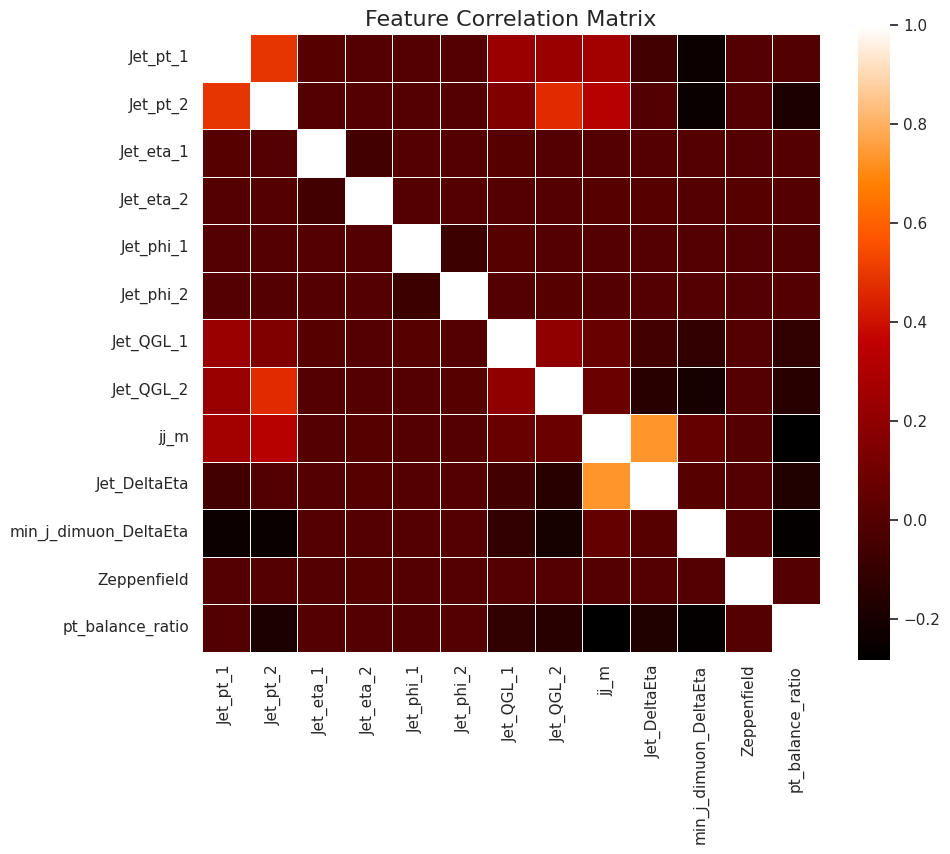

In [ ]:
# Imposta la dimensione della figura e la mappa colori
plt.figure(figsize=(10, 10))
sns.set(style="white")

# Heatmap con annotazioni e colori leggibili
sns.heatmap(corr_matrix, cmap="gist_heat", annot=False, fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": .75})

plt.title("Feature Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
df_shuffled = pairs_df.sample(frac=1, random_state=34).reset_index(drop=True)
df_shuffled

,Jet_pt_1,Jet_pt_2,Jet_eta_1,Jet_eta_2,Jet_phi_1,Jet_phi_2,Jet_QGL_1,Jet_QGL_2,label_1,label_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,label_SB,label
0,79.56250,51.84375,-1.238525,0.309143,1.732666,-1.020264,0.152710,0.899902,0,0,167.588470,1.547668,0.444313,0.191484,0.528076,0,0
1,126.68750,57.56250,-1.347412,-1.101318,-1.437012,-2.968750,0.827637,0.160645,1,0,121.942474,0.246094,0.321754,-3.497456,0.715498,1,0
2,103.37500,26.09375,-0.502441,-0.009193,1.543213,1.964111,0.144409,0.596680,0,1,35.394650,0.493248,0.662867,-1.112320,0.937853,1,0
3,36.62500,34.25000,0.874023,-1.735352,2.894043,-1.024658,0.369141,0.222168,0,0,138.187561,2.609375,0.377196,-0.929332,0.188526,0,0
4,110.68750,16.09375,-3.045410,4.401367,-0.509766,-1.580811,0.390625,-10.000000,1,0,1747.131592,7.446777,2.325449,0.430025,0.167400,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091399,80.06250,71.06250,2.249512,2.061035,1.123535,-1.458252,0.128662,0.150024,0,0,146.167664,0.188477,1.187113,11.041292,0.405194,0,0
2091400,139.75000,36.93750,2.330078,3.235352,1.624756,2.050293,0.587891,0.270508,1,0,78.805710,0.905273,4.454649,-1.462204,0.258130,1,0
2091401,53.40625,22.71875,-0.187225,-3.263672,-1.227783,-0.261719,0.132446,0.519043,0,0,158.059250,3.076447,1.268381,-0.366176,0.758537,0,0
2091402,95.93750,21.03125,-1.646240,-0.308716,-1.816895,1.093506,0.360840,0.161377,0,0,111.649734,1.337524,2.006133,1.534606,0.165534,0,0


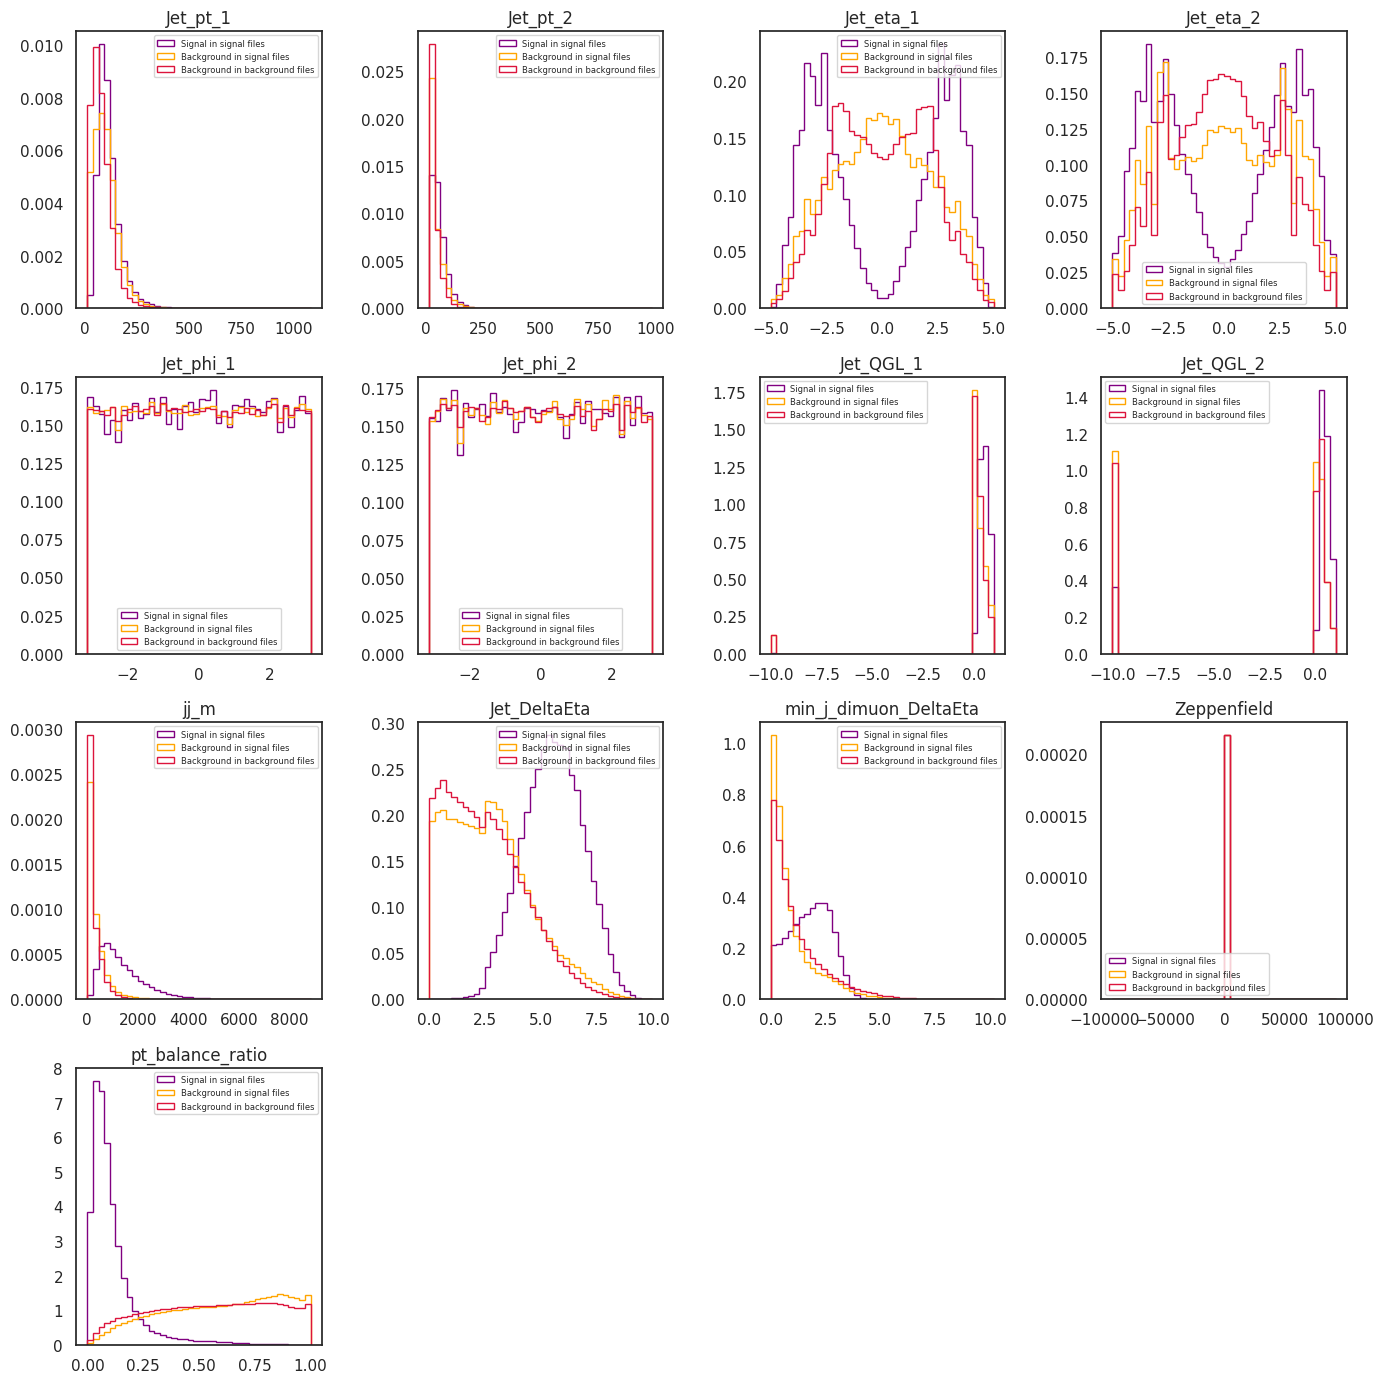

In [ ]:
plt.figure(figsize=(14, 14))
count_col = 1

df_SS = df_shuffled[df_shuffled["label"] == 1]
df_SB = df_shuffled[(df_shuffled["label"] == 0) & (df_shuffled["label_SB"] == 1)]
df_BB = df_shuffled[(df_shuffled["label"] == 0) & (df_shuffled["label_SB"] == 0)]

for col in sel_features:
    plt.subplot(4, 4, count_col)

    min_val = min(df_SS[col].min(), df_SB[col].min(), df_BB[col].min())
    max_val = max(df_SS[col].max(), df_SB[col].max(), df_BB[col].max())
    bins = np.linspace(min_val, max_val, 41)

    # Solo contorni
    plt.hist(df_SS[col], bins=bins, density=True, histtype='step', color='purple', linewidth=1, label='Signal in signal files')
    plt.hist(df_SB[col], bins=bins, density=True, histtype='step', color='orange', linewidth=1, label='Background in signal files')
    plt.hist(df_BB[col], bins=bins, density=True, histtype='step', color='crimson', linewidth=1, label='Background in background files')

    plt.title(col)
    plt.legend(fontsize='small')
    count_col += 1
    plt.legend(fontsize = 6)

plt.tight_layout()

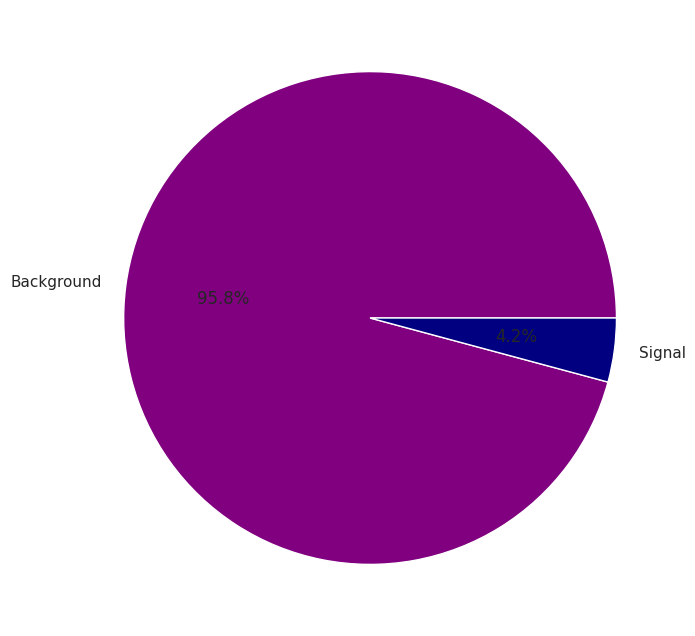

In [ ]:
# controllo che le classi siano bilanciate (cosa che già sappiamo che non è vera). Faccio un plot per vedere se le classi sono bilanciate
def pie_chart(y_all):
    # converte in Numpy Array una Series Pandas
    classes = np.array(y_all)
    # calcola la frazione di ciascuna classe
    arr_class_means = [np.mean(classes == i) for i in np.unique(classes)]
    # crea etichette per ciasciuna classe
    labels = ["Background", "Signal"]
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    colors = ["purple", "navy"]
    ax.pie(arr_class_means, labels=labels, autopct="%.1f%%", colors = colors)
    plt.show()

pie_chart(df_shuffled["label"])

In [ ]:
sel_features_with_flag = sel_features + ["Jet_QGL_1_is_missing", "Jet_QGL_2_is_missing"]
print(sel_features_with_flag)

['Jet_pt_1', 'Jet_pt_2', 'Jet_eta_1', 'Jet_eta_2', 'Jet_phi_1', 'Jet_phi_2', 'Jet_QGL_1', 'Jet_QGL_2', 'jj_m', 'Jet_DeltaEta', 'min_j_dimuon_DeltaEta', 'Zeppenfield', 'pt_balance_ratio', 'Jet_QGL_1_is_missing', 'Jet_QGL_2_is_missing']


In [ ]:
# divide i dati in un dataset di training, uno di validation e uno di test
df_train_x, df_rest2_x, df_train_SB, df_rest2_SB, df_train_y, df_rest2_y = train_test_split(df_shuffled[sel_features], df_shuffled["label_SB"], df_shuffled["label"], test_size=0.3, shuffle=True, random_state=92)
df_vali_x, df_test_x, df_vali_SB, df_test_SB, df_vali_y, df_test_y = train_test_split(df_rest2_x, df_rest2_SB, df_rest2_y, test_size=0.5, shuffle=True, random_state=56)

# stampa su schermo le dimensioni degli array
print('Dimensioni del dataset di training:', df_train_x.shape)
print("Dimensioni dell'array delle label di training:", df_train_y.shape)
print('Dimensioni del dataset di validation:', df_vali_x.shape)
print("Dimensioni dell'array delle label di validation:", df_vali_y.shape)
print('Dimensioni del dataset di test:', df_test_x.shape)
print("Dimensioni dell'array delle label di test:", df_test_y.shape)

Dimensioni del dataset di training: (1463982, 13)
Dimensioni dell'array delle label di training: (1463982,)
Dimensioni del dataset di validation: (313711, 13)
Dimensioni dell'array delle label di validation: (313711,)
Dimensioni del dataset di test: (313711, 13)
Dimensioni dell'array delle label di test: (313711,)


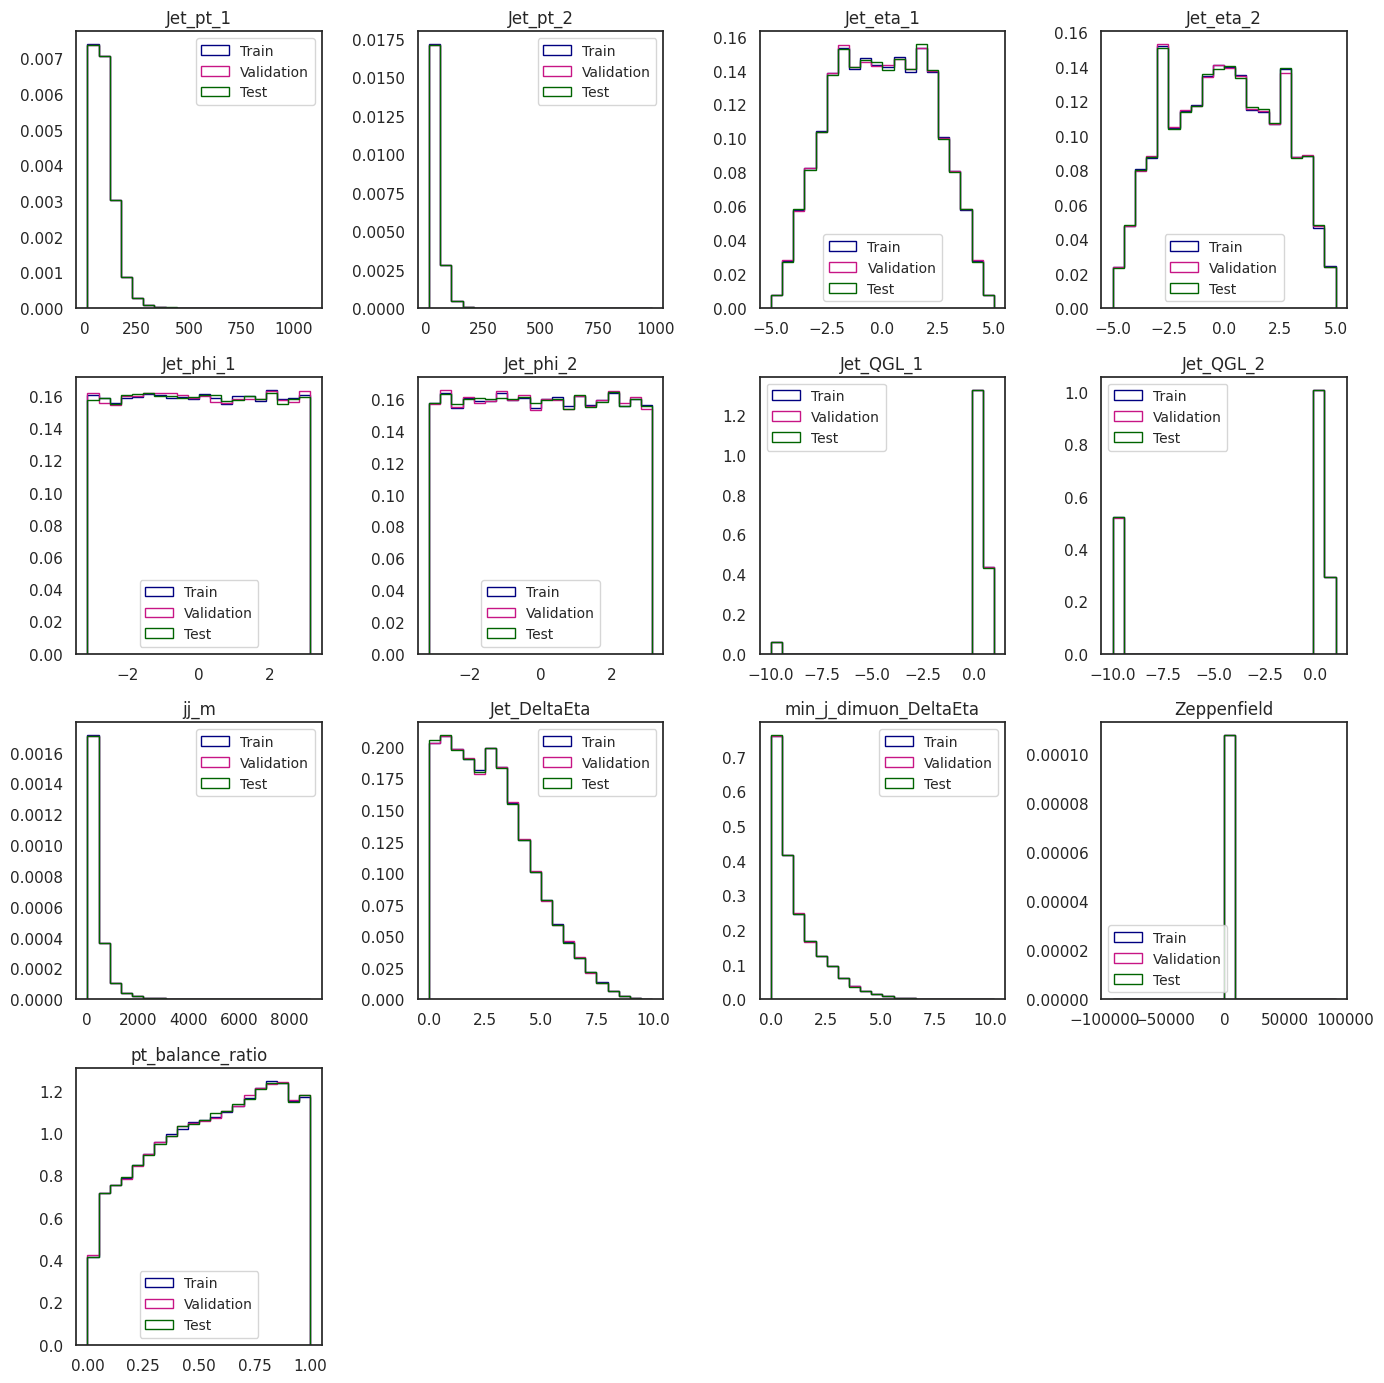

In [ ]:
plt.figure(figsize=(14, 14))
count_col = 1

for col in sel_features:
    plt.subplot(4, 4, count_col)

    min_val = min(df_train_x[col].min(), df_vali_x[col].min(), df_test_x[col].min())
    max_val = max(df_train_x[col].max(), df_vali_x[col].max(), df_test_x[col].max())
    bins = np.linspace(min_val, max_val, 21)

    # Solo contorni
    plt.hist(df_train_x[col], bins=bins, density=True, histtype='step', color='navy', linewidth=1, label='Train')
    plt.hist(df_vali_x[col], bins=bins, density=True, histtype='step', color='mediumvioletred', linewidth=1, label='Validation')
    plt.hist(df_test_x[col], bins=bins, density=True, histtype='step', color='darkgreen', linewidth=1, label='Test')

    plt.title(col)
    plt.legend(fontsize='small')
    count_col += 1

plt.tight_layout()

In [ ]:
df_train_x

,Jet_pt_1,Jet_pt_2,Jet_eta_1,Jet_eta_2,Jet_phi_1,Jet_phi_2,Jet_QGL_1,Jet_QGL_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio
1421449,62.25000,30.359375,0.951782,2.304688,0.802490,-1.343750,0.534180,0.146606,100.773270,1.352905,4.352367,-1.012033,0.601327
739944,26.31250,23.406250,2.261719,-2.775391,-2.819336,-2.832520,0.539551,-10.000000,306.055481,5.037109,0.094081,-0.161421,0.937047
1236107,17.50000,16.921875,-3.790039,2.369629,-0.533569,-1.689453,-10.000000,-10.000000,374.129364,6.159668,1.461207,0.136019,0.877808
1546885,44.53125,21.468750,-0.486572,-3.094727,1.163086,1.818115,0.266113,0.300293,109.038589,2.608154,0.197577,-0.628366,0.817439
1710157,109.93750,15.484375,-0.498413,-1.073975,0.602295,1.710693,0.165039,-10.000000,50.302818,0.575562,0.123629,-1.508137,0.965797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768331,50.15625,44.906250,-2.509766,2.418457,0.357666,0.569702,0.807617,0.755859,553.952332,4.928223,1.392085,0.631648,0.047370
1316882,64.25000,27.171875,3.396973,-3.043457,2.141602,1.983398,0.226685,0.210693,1044.428345,6.440430,1.255187,-0.689704,0.319096
31555,266.50000,16.703125,-2.011719,-0.769775,-1.664551,1.716064,0.118774,0.352295,160.871262,1.241943,0.049668,-1.005329,0.937989
1929258,32.81250,24.828125,0.415039,0.941406,1.069092,-2.572754,0.162476,0.254150,57.728279,0.526367,1.857389,-1.556042,0.718997


In [ ]:
# calcola media e deviazione standard di ciascuna feature
mean_training = df_train_x[sel_features].mean()
std_training = df_train_x[sel_features].std()

In [ ]:
def add_missing_mask(df, feature_cols, missing_idx):
    X = df[feature_cols].copy()

    # mask: 1 se era -10, 0 altrimenti
    mask = (X.iloc[:, missing_idx] == -10).astype(float)

    # imputazione: sostituisco -10 con la media del training (già calcolata e usata per normalizzare)
    for idx in missing_idx:
        col = feature_cols[idx]
        mean_val = mean_training[col]   # media calcolata sul training prima della normalizzazione
        X.loc[X[col] == -10, col] = mean_val

    # concatena mask come nuove colonne
    for j, idx in enumerate(missing_idx):
        X[f"{feature_cols[idx]}_is_missing"] = mask.iloc[:, j]

    return X

In [ ]:
missing_idx = [6, 7]
df_train_x = add_missing_mask(df_train_x, sel_features, missing_idx)
df_vali_x  = add_missing_mask(df_vali_x, sel_features, missing_idx)
df_test_x  = add_missing_mask(df_test_x, sel_features, missing_idx)
df_train_x

,Jet_pt_1,Jet_pt_2,Jet_eta_1,Jet_eta_2,Jet_phi_1,Jet_phi_2,Jet_QGL_1,Jet_QGL_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,Jet_QGL_1_is_missing,Jet_QGL_2_is_missing
1421449,62.25000,30.359375,0.951782,2.304688,0.802490,-1.343750,0.534180,0.146606,100.773270,1.352905,4.352367,-1.012033,0.601327,0.0,0.0
739944,26.31250,23.406250,2.261719,-2.775391,-2.819336,-2.832520,0.539551,-2.635850,306.055481,5.037109,0.094081,-0.161421,0.937047,0.0,1.0
1236107,17.50000,16.921875,-3.790039,2.369629,-0.533569,-1.689453,-0.031116,-2.635850,374.129364,6.159668,1.461207,0.136019,0.877808,1.0,1.0
1546885,44.53125,21.468750,-0.486572,-3.094727,1.163086,1.818115,0.266113,0.300293,109.038589,2.608154,0.197577,-0.628366,0.817439,0.0,0.0
1710157,109.93750,15.484375,-0.498413,-1.073975,0.602295,1.710693,0.165039,-2.635850,50.302818,0.575562,0.123629,-1.508137,0.965797,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768331,50.15625,44.906250,-2.509766,2.418457,0.357666,0.569702,0.807617,0.755859,553.952332,4.928223,1.392085,0.631648,0.047370,0.0,0.0
1316882,64.25000,27.171875,3.396973,-3.043457,2.141602,1.983398,0.226685,0.210693,1044.428345,6.440430,1.255187,-0.689704,0.319096,0.0,0.0
31555,266.50000,16.703125,-2.011719,-0.769775,-1.664551,1.716064,0.118774,0.352295,160.871262,1.241943,0.049668,-1.005329,0.937989,0.0,0.0
1929258,32.81250,24.828125,0.415039,0.941406,1.069092,-2.572754,0.162476,0.254150,57.728279,0.526367,1.857389,-1.556042,0.718997,0.0,0.0


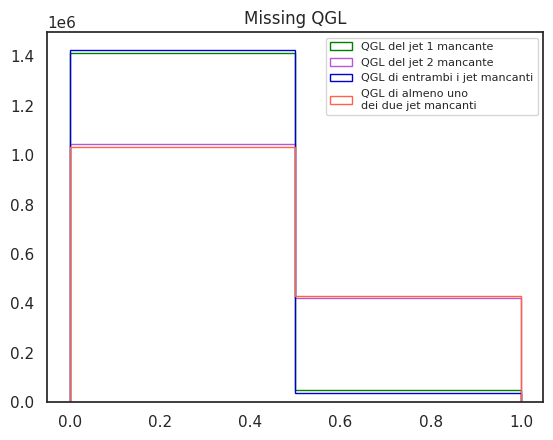

In [ ]:
df_both_QGL = ((df_train_x["Jet_QGL_1_is_missing"] == 1) & (df_train_x["Jet_QGL_2_is_missing"] == 1)).astype(int)
df_one_QGL = ((df_train_x["Jet_QGL_1_is_missing"] == 1) | (df_train_x["Jet_QGL_2_is_missing"] == 1)).astype(int)

plt.hist(df_train_x["Jet_QGL_1_is_missing"], bins=2, density=False, histtype='step', color='green', linewidth=1, label='QGL del jet 1 mancante')
plt.hist(df_train_x["Jet_QGL_2_is_missing"], bins=2, density=False, histtype='step', color='mediumorchid', linewidth=1, label='QGL del jet 2 mancante')
plt.hist(df_both_QGL, bins=2, density=False, histtype='step', color='mediumblue', linewidth=1, label='QGL di entrambi i jet mancanti')
plt.hist(df_one_QGL, bins=2, density=False, histtype='step', color='tomato', linewidth=1, label='QGL di almeno uno\ndei due jet mancanti')
plt.title("Missing QGL")
plt.legend(loc = "upper right", fontsize = 8)
plt.show()


In [ ]:
# normalizza i dati da dare in input alla rete neurale
df_train_x[sel_features]  = (df_train_x[sel_features] - mean_training)/std_training
df_vali_x[sel_features] = (df_vali_x[sel_features] - mean_training)/std_training
df_test_x[sel_features] = (df_test_x[sel_features] - mean_training)/std_training

mean_training_af = df_train_x[sel_features].mean()
std_training_af = df_train_x[sel_features].std()
mean_vali = df_vali_x[sel_features].mean()
std_vali = df_vali_x[sel_features].std()
mean_test = df_test_x[sel_features].mean()
std_test = df_test_x[sel_features].std()

print("Media del training set:\n" + str(mean_training_af) + "\n")
print("Deviazione standard del training set:\n" + str(std_training_af) + "\n")
print("Media del validation set:\n" + str(mean_vali) + "\n")
print("Deviazione standard del validation set:\n" + str(std_vali) + "\n")
print("Media del test set:\n" + str(mean_test) + "\n")
print("Deviazione standard del test set:\n" + str(std_test) + "\n")

Media del training set:
Jet_pt_1                -1.459114e-07
Jet_pt_2                -2.175082e-07
Jet_eta_1               -1.695008e-08
Jet_eta_2                1.741128e-08
Jet_phi_1               -9.370096e-09
Jet_phi_2                2.016811e-09
Jet_QGL_1                1.782719e-01
Jet_QGL_2                4.520115e-01
jj_m                     1.111175e-07
Jet_DeltaEta             5.594125e-07
min_j_dimuon_DeltaEta    7.721209e-08
Zeppenfield              1.511306e-10
pt_balance_ratio        -3.162902e-07
dtype: float32

Deviazione standard del training set:
Jet_pt_1                 0.999911
Jet_pt_2                 0.999798
Jet_eta_1                1.000051
Jet_eta_2                1.000199
Jet_phi_1                0.999976
Jet_phi_2                0.999966
Jet_QGL_1                0.123841
Jet_QGL_2                0.288096
jj_m                     1.000098
Jet_DeltaEta             0.999983
min_j_dimuon_DeltaEta    1.000071
Zeppenfield              0.999997
pt_balance_ratio    

In [ ]:
# converto le feature e le label in tensori torch
X_train = torch.tensor(df_train_x[sel_features_with_flag].to_numpy(), dtype=torch.float32)
X_vali  = torch.tensor(df_vali_x[sel_features_with_flag].to_numpy(), dtype=torch.float32)
X_test  = torch.tensor(df_test_x[sel_features_with_flag].to_numpy(), dtype=torch.float32)
Y_train = torch.tensor(df_train_y.to_numpy(), dtype=torch.float32)
Y_vali  = torch.tensor(df_vali_y.to_numpy(), dtype=torch.float32)
Y_test = torch.tensor(df_test_y.to_numpy(), dtype=torch.float32)

Y_SB_train = torch.tensor(df_train_SB.to_numpy(), dtype=torch.float32)
Y_SB_vali = torch.tensor(df_vali_SB.to_numpy(), dtype=torch.float32)
Y_SB_test = torch.tensor(df_test_SB.to_numpy(), dtype=torch.float32)

In [ ]:
#effettua una PCA a 8 componenti sul dataset di train e stampa la varianza di ciascuna componente e quella totale di tutte le componenti
pca = PCA(n_components=8)
pca_result_train = pca.fit_transform(X_train.view(-1, 15))
exp_var_train = pca.explained_variance_ratio_

for i in range(0,len(exp_var_train)):
  print('Explained variance dataset train componente: ', i, ' = ', exp_var_train[i])
print('Explained variance totale delle prime 8 componenti della PCA per dataset di train: {}\n'.format(sum(exp_var_train)))

#effettua una PCA a 8 componenti sul dataset di validation e stampa la varianza di ciascuna componente e quella totale di tutte le componenti
pca = PCA(n_components=8)
pca_result_vali = pca.fit_transform(X_vali.view(-1, 15))
exp_var_vali = pca.explained_variance_ratio_

for i in range(0,len(exp_var_vali)):
  print('Explained variance dataset validation componente: ', i, ' = ', exp_var_vali[i])
print('Explained variance totale delle prime 8 componenti della PCA per dataset di validation: {}\n'.format(sum(exp_var_vali)))

#effettua una PCA a 8 componenti sul dataset di test high e stampa la varianza di ciascuna componente e quella totale di tutte le componenti
pca = PCA(n_components=8)
pca_result_test = pca.fit_transform(X_test.view(-1, 15))
exp_var_test = pca.explained_variance_ratio_

for i in range(0,len(exp_var_test)):
  print('Explained variance dataset test high componente: ', i, ' = ', exp_var_test[i])
print('Explained variance totale delle prime 8 componenti della PCA per dataset di test: {}\n'.format(sum(exp_var_test)))

Explained variance dataset train componente:  0  =  0.18261322236628422
Explained variance dataset train componente:  1  =  0.14488262655032483
Explained variance dataset train componente:  2  =  0.0963787950428567
Explained variance dataset train componente:  3  =  0.09526802784328174
Explained variance dataset train componente:  4  =  0.09313894222077895
Explained variance dataset train componente:  5  =  0.08820632578820473
Explained variance dataset train componente:  6  =  0.08327289697371036
Explained variance dataset train componente:  7  =  0.08117283800613684
Explained variance totale delle prime 8 componenti della PCA per dataset di train: 0.8649336747915782

Explained variance dataset validation componente:  0  =  0.23352869646366645
Explained variance dataset validation componente:  1  =  0.15291742716013962
Explained variance dataset validation componente:  2  =  0.12203388782571871
Explained variance dataset validation componente:  3  =  0.08124566263180409
Explained vari

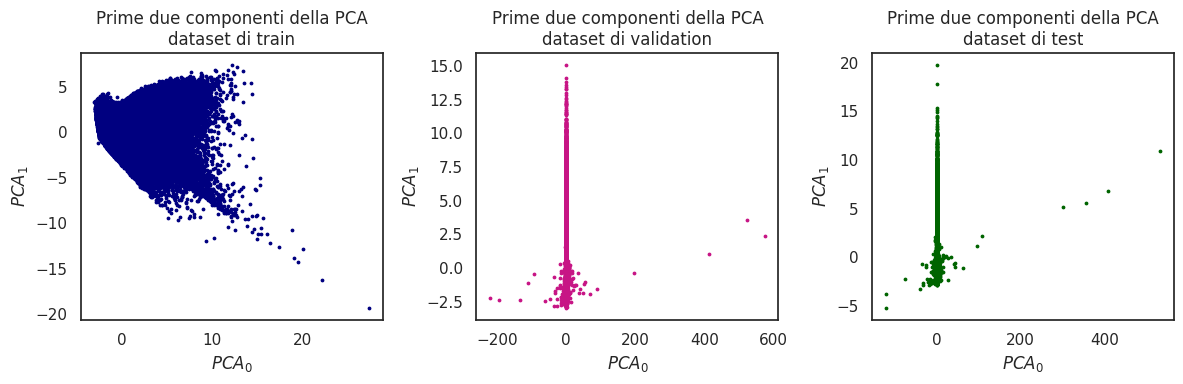

In [ ]:
plt.figure(figsize=(12, 4))

# plot del dataset di train ridotto dimensionalmente mediante PCA
plt.subplot(1, 3, 1)
plt.scatter(pca_result_train[:,0], pca_result_train[:,1], s = 3, color = "navy")
plt.title("Prime due componenti della PCA\ndataset di train")
plt.xlabel("$PCA_0$")
plt.ylabel("$PCA_1$")

# plot del dataset di validation ridotto dimensionalmente mediante PCA
plt.subplot(1, 3, 2)
plt.scatter(pca_result_vali[:,0], pca_result_vali[:,1], s = 3, color = "mediumvioletred")
plt.title("Prime due componenti della PCA\ndataset di validation")
plt.xlabel("$PCA_0$")
plt.ylabel("$PCA_1$")

# plot del dataset di test ridotto dimensionalmente mediante PCA
plt.subplot(1, 3, 3)
plt.scatter(pca_result_test[:,0], pca_result_test[:,1], s = 3, color = "darkgreen")
plt.title("Prime due componenti della PCA\ndataset di test")
plt.xlabel("$PCA_0$")
plt.ylabel("$PCA_1$")

plt.tight_layout()

## Costruzione della DNN

In [ ]:
class BalancedDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last

        # labels: se TensorDataset, le label sono dataset.tensors[1]
        labels = dataset.tensors[1].numpy()
        # se le label sono intere (0,1,2,...)
        classes = torch.tensor(labels, dtype=torch.long)
        class_counts = torch.bincount(classes)
        weights = 1. / class_counts[classes]
        sampler = torch.utils.data.WeightedRandomSampler(weights, len(dataset))

        super().__init__(
            dataset,
            batch_size=batch_size,
            sampler=sampler,
            shuffle=False,  # shuffle=False quando si usa sampler
            drop_last=drop_last
        )

In [ ]:
# definizione della batch size
batch_size_train=4096
batch_size_vali=4096
batch_size_test=4096

# creazione dei dataloader
dataset_train = TensorDataset(X_train, Y_train)
dataloader_train = BalancedDataLoader(dataset_train, batch_size=batch_size_train, shuffle=False, drop_last=True)

dataset_vali = TensorDataset(X_vali, Y_vali, Y_SB_vali)
dataloader_vali = BalancedDataLoader(dataset_vali, batch_size=batch_size_vali, shuffle=False, drop_last = True)

dataset_test = TensorDataset(X_test, Y_test)
dataloader_test = BalancedDataLoader(dataset_test, batch_size=batch_size_test, shuffle = False, drop_last = True)

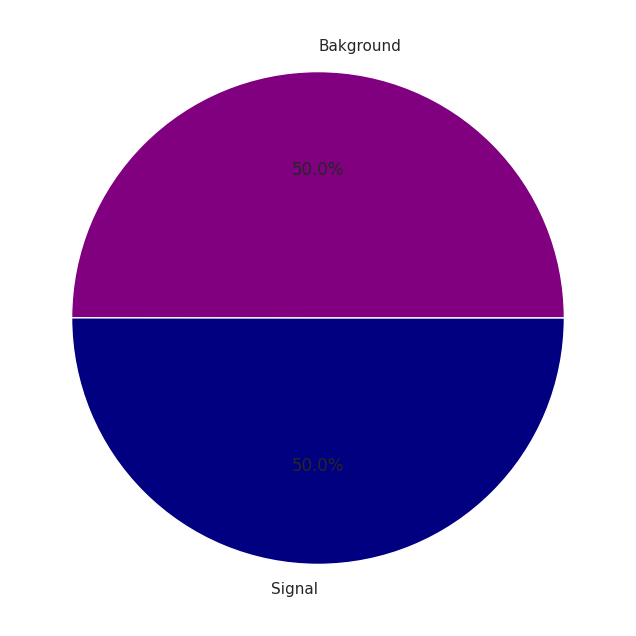

In [ ]:
# controllo che le classi siano bilanciate (cosa che già sappiamo che non è vera)
#faccio un plot per vedere se le classi sono bilanciate
def pie_chart2(y_all):
    y_all = np.array(y_all)  # assicurati che sia un array numpy
    classes = y_all           # sono già le classi come 0,1
    arr_class_means = [np.mean(classes == i) for i in np.unique(classes)]  # frazione del dataset per classe
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    labels = ["Bakground", "Signal"]
    colors = ["purple", "navy"]
    ax.pie(arr_class_means, labels=labels, autopct="%.1f%%", colors = colors)
    plt.show()
balanced = []
for _, batch_labels in dataloader_train:
  balanced.extend(batch_labels.numpy())

pie_chart2(balanced)

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, dropout_p=0.3):
        super(DNN, self).__init__()

        self.linear = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # batch normalization

        self.linear2 = nn.Linear(hidden_size, 2*hidden_size)
        self.bn2 = nn.BatchNorm1d(2*hidden_size)

        self.linear3 = nn.Linear(2*hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        self.linear4 = nn.Linear(hidden_size, out_size)

        self.act = nn.ReLU()
        self.drop = nn.Dropout(p=dropout_p)  # dropout

    def forward(self, x):
        x = self.linear(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.drop(x)

        x = self.linear2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.drop(x)

        x = self.linear3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.drop(x)

        x = self.linear4(x)
        return x

In [ ]:
input_size = X_train.shape[1]
output_size = 1
hidden_size = 64
dnn = DNN(input_size, hidden_size, output_size, dropout_p = 0.1)

#stampa su schermo un sommario del modello di DNN utilizzato
print(dnn)

if torch.cuda.is_available():
  summary(dnn.cuda(), input_size=(15,))
else:
  summary(dnn, input_size=(15,))

DNN(
  (linear): Linear(in_features=15, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=64, out_features=1, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.1, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,024
       BatchNorm1d-2                   [-1, 64]             128
              ReLU-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
            Linear-5        

## Allenamento della rete neurale

In [ ]:
# definizione della funzione di loss
criterion = nn.BCEWithLogitsLoss()

#definizione del learning rate
LR = 5e-5

#definizione dell'ottimizzatore
optimizer = torch.optim.Adam(params=dnn.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# controllo se la GPU è disponibile
if torch.cuda.is_available():
  print('Numero di GPU disponibili:', torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu'
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili: 1
Tesla T4
Computation device: cuda



In [ ]:
# Impostazioni
epochs = 40
hist_loss = []
hist_val_loss = []

# Metti il modello in modalità device
dnn.to(device)

for epoch in range(epochs):
    t0 = time.time()

    # --- TRAINING STEP ---
    dnn.train()
    train_loss = 0
    counter = 0

    for X_batch, Y_batch in dataloader_train:
        counter += 1
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.float().to(device)

        # forward pass
        y_pred = dnn(X_batch).flatten()  # output [batch_size]

        # BCE con pesi
        loss = criterion(y_pred, Y_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= counter
    hist_loss.append(train_loss)


    # --- VALIDATION STEP ---
    dnn.eval()
    val_loss = 0
    val_counter = 0

    all_labels = []
    all_labels_SB = []
    all_probs = []
    all_weights = []

    with torch.no_grad():
        for X_batch, Y_batch, Y_SB in dataloader_vali:
            val_counter += 1
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.float().to(device)

            y_pred = dnn(X_batch).flatten()
            loss = criterion(y_pred, Y_batch)

            val_loss += loss.item()

            probs = torch.sigmoid(y_pred)  # probabilità [0,1]

            all_labels.extend(Y_batch.cpu().numpy().tolist())
            all_labels_SB.extend(Y_SB.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())

    val_loss /= val_counter
    hist_val_loss.append(val_loss)

    all_labels = np.array(all_labels)
    all_labels_SB = np.array(all_labels_SB)
    all_probs = np.array(all_probs)

    elapsed_time = time.time() - t0
    torch.cuda.empty_cache()

    print(f"Epoch: {epoch+1}/{epochs}, Time: {elapsed_time:.2f} s, Train loss: {train_loss:.8f}, Validation loss: {val_loss:.8f}")


Epoch: 1/40, Time: 28.48 s, Train loss: 0.42020014, Validation loss: 0.26733135
Epoch: 2/40, Time: 25.55 s, Train loss: 0.23556009, Validation loss: 0.20015682
Epoch: 3/40, Time: 30.44 s, Train loss: 0.19718541, Validation loss: 0.18002716
Epoch: 4/40, Time: 19.59 s, Train loss: 0.18121686, Validation loss: 0.16916124
Epoch: 5/40, Time: 23.72 s, Train loss: 0.17171307, Validation loss: 0.16133666
Epoch: 6/40, Time: 25.65 s, Train loss: 0.16785672, Validation loss: 0.15920714
Epoch: 7/40, Time: 27.65 s, Train loss: 0.16330088, Validation loss: 0.15638336
Epoch: 8/40, Time: 25.75 s, Train loss: 0.16048536, Validation loss: 0.15401640
Epoch: 9/40, Time: 24.84 s, Train loss: 0.15788208, Validation loss: 0.15067940
Epoch: 10/40, Time: 28.09 s, Train loss: 0.15630932, Validation loss: 0.14902210
Epoch: 11/40, Time: 31.82 s, Train loss: 0.15474015, Validation loss: 0.14704242
Epoch: 12/40, Time: 23.60 s, Train loss: 0.15325713, Validation loss: 0.14732990
Epoch: 13/40, Time: 20.62 s, Train lo

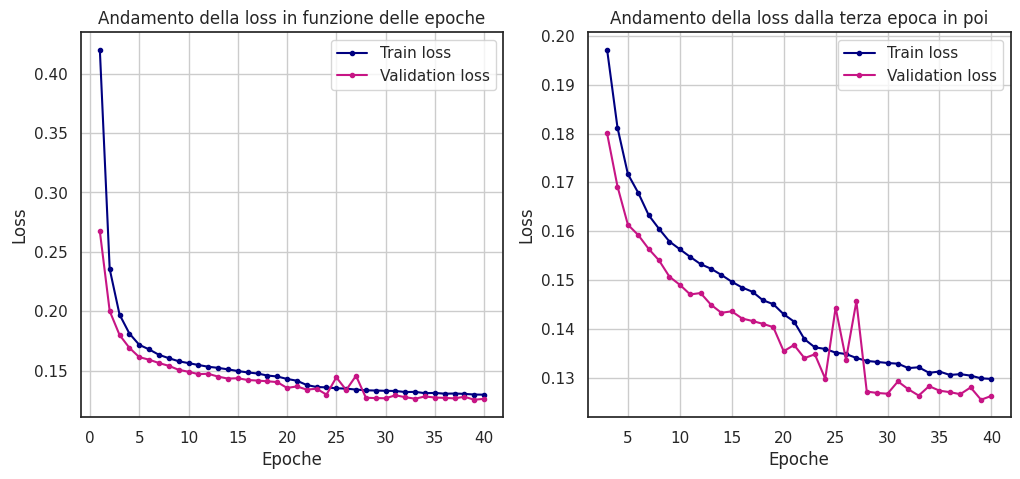

In [ ]:
plt.figure(figsize = (12, 5))

# andamento della loss completo, con tutte le epoche di training
plt.subplot(1, 2, 1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color="navy", linestyle='-', label='Train loss', marker = "o", markersize = 3)
plt.plot(range(1,len(hist_val_loss)+1), hist_val_loss, color="mediumvioletred", linestyle='-', label='Validation loss', marker = "o", markersize = 3)
plt.title("Andamento della loss in funzione delle epoche")
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# andamento della loss dalla terza epoca in poi
plt.subplot(1, 2, 2)
plt.plot(range(3,len(hist_loss)+1), hist_loss[2:], color="navy", linestyle='-', label='Train loss', marker = "o", markersize = 3)
plt.plot(range(3,len(hist_val_loss)+1), hist_val_loss[2:], color="mediumvioletred", linestyle='-', label='Validation loss', marker = "o", markersize = 3)
plt.title("Andamento della loss dalla terza epoca in poi")
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

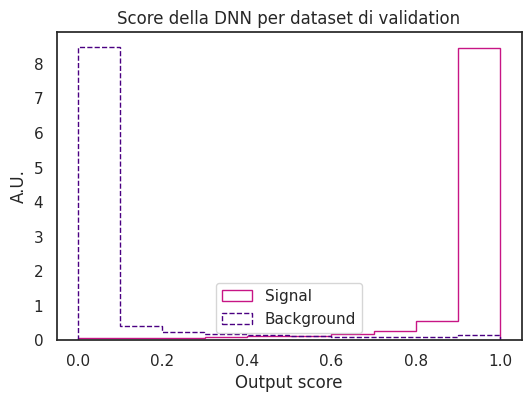

In [ ]:
# Supponendo che all_labels e all_probs siano numpy array
mask_signal = (all_labels == 1)
mask_background = (all_labels == 0)

all_probs = all_probs.flatten()

plt.figure(figsize=(6, 4))
plt.hist(all_probs[mask_signal], label='Signal', density=True, histtype='step', linestyle = "--", color="mediumvioletred")
plt.hist(all_probs[mask_background], label='Background', density=True, histtype='step', linestyle = "--", color="indigo")
plt.title("Score della DNN per dataset di validation")
plt.xlabel("Output score")
plt.ylabel("A.U.")
plt.legend()

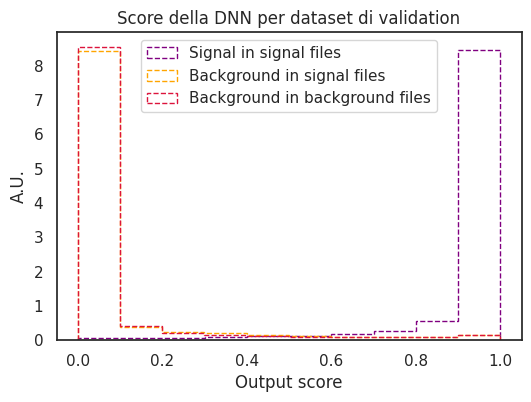

In [ ]:
# Supponendo che all_labels e all_probs siano numpy array
mask_SS = (all_labels == 1) & (all_labels_SB == 1)
mask_SB = (all_labels == 0) & (all_labels_SB == 1)
mask_BB = (all_labels == 0) & (all_labels_SB == 0)

all_probs = all_probs.flatten()

plt.figure(figsize=(6, 4))
plt.hist(all_probs[mask_SS], label='Signal in signal files', density=True, histtype='step', linestyle = "--", color="purple")
plt.hist(all_probs[mask_SB], label='Background in signal files', density=True, histtype='step', linestyle = "--", color="orange")
plt.hist(all_probs[mask_BB], label='Background in background files', density=True, histtype='step', linestyle = "--", color="crimson")
plt.title("Score della DNN per dataset di validation")
plt.xlabel("Output score")
plt.ylabel("A.U.")
plt.legend()

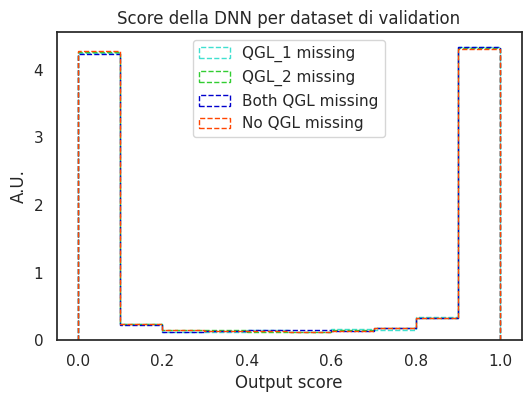

In [ ]:
mask_QGL1_missing = ((df_vali_x["Jet_QGL_1_is_missing"] == 1) & (df_vali_x["Jet_QGL_2_is_missing"] == 0))[0:311296]
mask_QGL2_missing = ((df_vali_x["Jet_QGL_2_is_missing"] == 1) & (df_vali_x["Jet_QGL_1_is_missing"] == 0))[0:311296]
mask_both_QGL_missing = ((df_vali_x["Jet_QGL_1_is_missing"] == 1) & (df_vali_x["Jet_QGL_2_is_missing"] == 1))[0:311296]
mask_no_QGL_missing = ((df_vali_x["Jet_QGL_1_is_missing"] == 0) & (df_vali_x["Jet_QGL_2_is_missing"] == 0))[0:311296]

all_probs = all_probs.flatten()

plt.figure(figsize=(6, 4))
plt.hist(all_probs[mask_QGL1_missing], label='QGL_1 missing', density=True, histtype='step', linestyle = "--", color="turquoise")
plt.hist(all_probs[mask_QGL2_missing], label='QGL_2 missing', density=True, histtype='step', linestyle = "--", color="limegreen")
plt.hist(all_probs[mask_both_QGL_missing], label='Both QGL missing', density=True, histtype='step', linestyle = "--", color="mediumblue")
plt.hist(all_probs[mask_no_QGL_missing], label='No QGL missing', density=True, histtype='step', linestyle = "--", color="orangered")
plt.title("Score della DNN per dataset di validation")
plt.xlabel("Output score")
plt.ylabel("A.U.")
plt.legend()

## Prestazioni della rete neurale

In [ ]:
def compute_confusion_matrix(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # aggiunto per ROC

    with torch.no_grad():
        for X_batch, Y_batch, *rest in dataloader:  # supporta anche dataloader con 2 o più elementi
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.cpu().numpy()  # portiamo su CPU

            logits = model(X_batch).flatten()
            probs = torch.sigmoid(logits)  # probabilità [0,1]

            preds = (probs > threshold).int().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(Y_batch)
            all_probs.extend(probs.cpu().numpy())  # salva le probabilità

    # Confusion matrix: righe = vere, colonne = predette
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=3)

    return cm, report, all_labels, all_preds, all_probs

In [ ]:
cm_train, report_train, y_true_train, y_pred_train, y_prob_train = compute_confusion_matrix(dnn, dataloader_train, device)
print("\nClassification Report - Train:\n", report_train)

cm_vali, report_vali, y_true_vali, y_pred_vali, y_prob_vali = compute_confusion_matrix(dnn, dataloader_vali, device)
print("\nClassification Report - Validation:\n", report_vali)

cm_test, report_test, y_true_test, y_pred_test, y_prob_test = compute_confusion_matrix(dnn, dataloader_test, device)
print("\n\nClassification Report - Test:\n", report_test)


Classification Report - Train:
               precision    recall  f1-score   support

         0.0      0.961     0.945     0.953    730546
         1.0      0.946     0.962     0.954    731726

    accuracy                          0.953   1462272
   macro avg      0.953     0.953     0.953   1462272
weighted avg      0.953     0.953     0.953   1462272


Classification Report - Validation:
               precision    recall  f1-score   support

         0.0      0.958     0.944     0.951    155870
         1.0      0.945     0.958     0.951    155426

    accuracy                          0.951    311296
   macro avg      0.951     0.951     0.951    311296
weighted avg      0.951     0.951     0.951    311296



Classification Report - Test:
               precision    recall  f1-score   support

         0.0      0.958     0.944     0.951    155632
         1.0      0.945     0.959     0.952    155664

    accuracy                          0.952    311296
   macro avg      0.952 

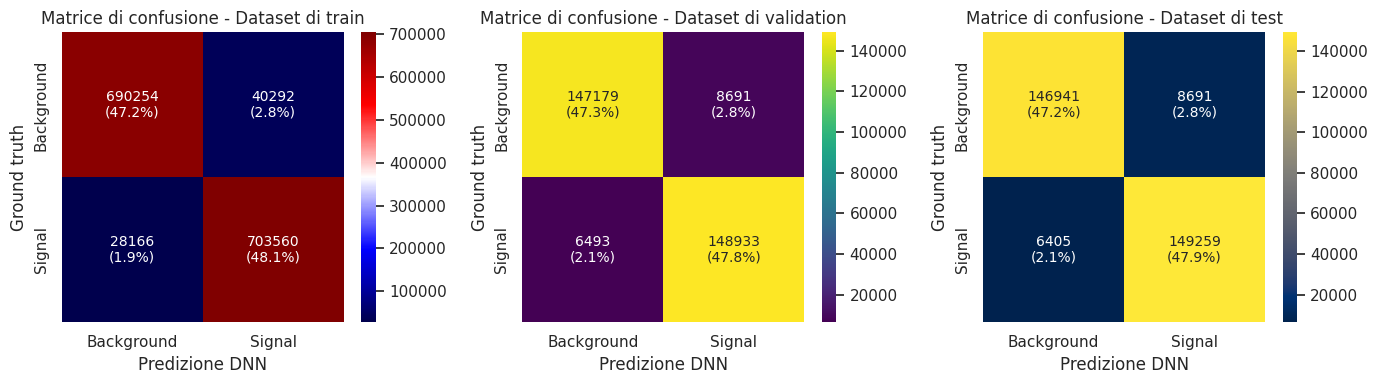

In [ ]:
# calcola le percentuali rispetto al totale per il dataset di train
total_train = cm_train.sum()
cm_train_percent_total = cm_train.astype('float')/total_train
cm_train_annot_total = np.array([["{0}\n({1:.1%})".format(count, percent) for count, percent in zip(row_counts, row_percent)] for row_counts, row_percent in zip(cm_train, cm_train_percent_total)])

# calcola le percentuali rispetto al totale per il dataset di validation
total_vali = cm_vali.sum()
cm_vali_percent_total = cm_vali.astype('float')/total_vali
cm_vali_annot_total = np.array([["{0}\n({1:.1%})".format(count, percent) for count, percent in zip(row_counts, row_percent)] for row_counts, row_percent in zip(cm_vali, cm_vali_percent_total)])

# calcola le percentuali rispetto al totale per il dataset di test
total_test = cm_test.sum()
cm_test_percent_total = cm_test.astype('float')/total_test
cm_test_annot_total = np.array([["{0}\n({1:.1%})".format(count, percent) for count, percent in zip(row_counts, row_percent)] for row_counts, row_percent in zip(cm_test, cm_test_percent_total)])

# crea una figura con tre subplots affiancati
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

x_labels = ['Background', 'Signal']
y_labels = ['Background', 'Signal']

# heatmap per dataset di train
sns.heatmap(cm_train, annot=cm_train_annot_total, fmt='', cmap='seismic', cbar=True, annot_kws={"size": 10}, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
axes[0].set_title('Matrice di confusione - Dataset di train')
axes[0].set_xlabel('Predizione DNN')
axes[0].set_ylabel('Ground truth')

# heatmap per dataset di validation
sns.heatmap(cm_vali, annot=cm_vali_annot_total, fmt='', cmap='viridis', cbar=True, annot_kws={"size": 10}, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
axes[1].set_title('Matrice di confusione - Dataset di validation')
axes[1].set_xlabel('Predizione DNN')
axes[1].set_ylabel('Ground truth')

# heatmap per dataset di test
sns.heatmap(cm_test, annot=cm_test_annot_total, fmt='', cmap='cividis', cbar=True, annot_kws={"size": 10}, xticklabels=x_labels, yticklabels=y_labels, ax=axes[2])
axes[2].set_title('Matrice di confusione - Dataset di test')
axes[2].set_xlabel('Predizione DNN')
axes[2].set_ylabel('Ground truth')

plt.tight_layout()
plt.show()

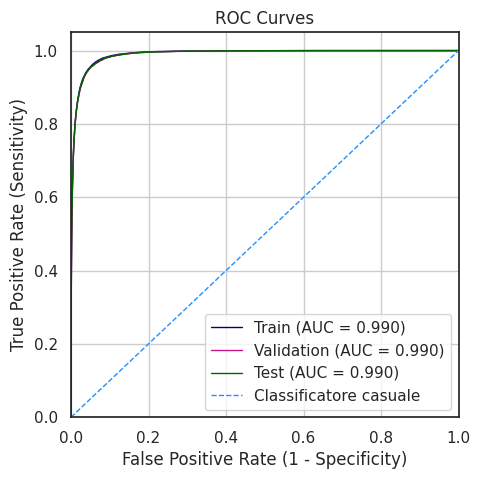

In [ ]:
# Lista dei dataset per ciclarli
datasets = [("Train", y_true_train, y_prob_train), ("Validation", y_true_vali, y_prob_vali), ("Test", y_true_test, y_prob_test)]
colors = ["navy", "mediumvioletred", "darkgreen"]

plt.figure(figsize=(5, 5))

count = 0
for label, y_true, y_prob in datasets:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=1, label=f'{label} (AUC = {roc_auc:.3f})', color = colors[count])
    count += 1

# Linea diagonale casuale
plt.plot([0, 1], [0, 1], color='dodgerblue', linewidth=1, linestyle='--', label = "Classificatore casuale")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

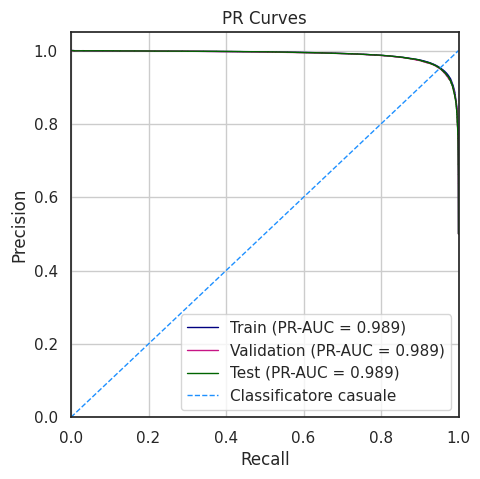

In [ ]:
plt.figure(figsize=(5, 5))

count = 0
for label, y_true, y_prob in datasets:
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, linewidth=1, label=f'{label} (PR-AUC = {pr_auc:.3f})', color = colors[count])
    count += 1

# Linea diagonale casuale
plt.plot([0, 1], [0, 1], color='dodgerblue', linewidth=1, linestyle='--', label = "Classificatore casuale")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
sample_size = 1000 # Puoi cambiare questo valore
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sampled = X_train[sample_indices]

# Sposta tutto il modello sulla CPU
dnn = dnn.to('cpu')

# Define the prediction function
def predict_fn(x):
    # Ensure the input 'x' is a PyTorch tensor, even if it comes from a NumPy array
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()

    # Run the model, handle the output shape, and return a NumPy array
    return dnn(x).detach().cpu().squeeze().numpy()

# Define the masker for the explainer using a NumPy array
masker = shap.maskers.Independent(X_train_sampled.cpu().numpy())

# Create the explainer by passing the prediction function and the masker
explainer = shap.Explainer(predict_fn, masker)

# Now, compute the SHAP values, ensuring you pass a NumPy array
X_train_np = X_train_sampled.detach().cpu().numpy()
shap_values = explainer(X_train_np)

PermutationExplainer explainer: 1001it [00:56, 15.75it/s]                         


/tmp/ipython-input-3861036944.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_sampled.detach().cpu().numpy(), feature_names=sel_features_with_flag, cmap = "plasma")


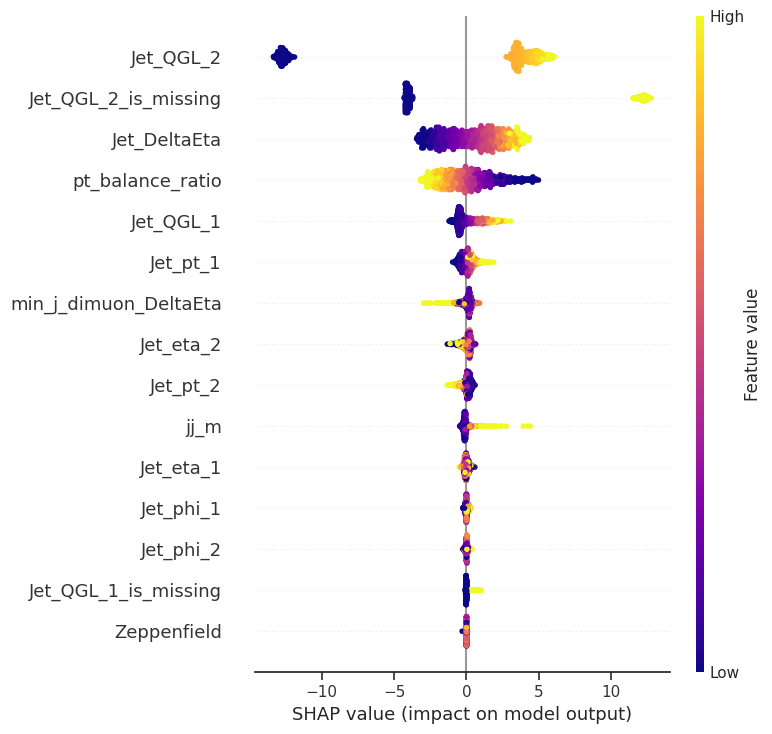

In [ ]:
shap.summary_plot(shap_values, X_train_sampled.detach().cpu().numpy(), feature_names=sel_features_with_flag, cmap = "plasma")

## Calcola i migliori jet VBF per ciascun evento

In [ ]:
df_rest = df_rest.reset_index(drop=True)
df_rest

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,Jet_pt,Jet_eta,Jet_phi,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,Jet_QGL,label,GenWeight,label_SB
0,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,"[112.0625, 108.625, 46.78125]","[-1.3364258, 1.5812988, -0.46020508]","[-2.769043, 0.2541504, 0.4177246]","[500.26776, 159.51082, 172.89824]","[2.9177246, 0.8762207, 2.041504]","[0.3777628, 1.6637411, 0.3777628]","[0.8097189, 1.5319433, -0.05746119]","[0.37028682, 0.23447411, 0.9984878]","[0.5283203, 0.12072754, 0.15124512]","[0, 0, 0]",211.929688,0
1,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,"[118.0625, 92.0625, 81.5, 66.1875]","[-2.491211, 2.4345703, -1.1870117, -0.694458]","[-2.2895508, 1.0566406, 1.3793945, -1.3828125]","[1232.7509, 235.526, 197.5029, 516.96423, 386....","[4.9257812, 1.3041992, 1.7967529, 3.621582, 3....","[0.011175156, 0.011175156, 0.011175156, 1.2930...","[0.30943805, -0.21651305, -0.022079855, -0.759...","[0.052789956, 0.18217829, 0.76523423, 0.927957...","[0.7011719, 0.49291992, 0.16137695, 0.1361084]","[1, 1, 0, 0]",4.184326,1
2,123.683891,1.952896,57.585044,1.371230,2.551013,0.658053,"[95.0625, 94.375, 74.5625, 31.890625]","[1.885498, -1.3955078, 4.0058594, 0.24179077]","[0.24639893, 2.9516602, -0.9448242, 2.6689453]","[505.63574, 234.67285, 144.63449, 1253.741, 10...","[3.2810059, 2.1203613, 1.6437073, 5.401367, 1....","[0.29457593, 0.29457593, 0.29457593, 1.8257854...","[-0.08095804, 1.1471382, 0.3353172, 0.7543455,...","[0.35376367, 0.80675566, 0.7131837, 0.04414053...","[0.1381836, 0.14868164, 0.55859375, 0.1352539]","[0, 1, 1, 0]",4.184326,1
3,124.333474,2.499963,11.753592,-1.930161,-2.914424,-0.295646,"[88.0, 61.5625, 61.125, 52.6875, 18.65625]","[-2.2167969, 3.2583008, -1.5957031, -0.8006592...","[-2.368164, -0.069381714, 0.8182373, 2.5766602...","[1140.3165, 153.86734, 135.70947, 105.975334, ...","[5.4750977, 0.62109375, 1.4161377, 2.0460815, ...","[2.0555296, 2.0555296, 2.0555296, 2.0555296, 2...","[0.1472956, -2.6139102, -0.85919064, -0.442288...","[0.45233092, 0.24107583, 0.81260157, 0.9492399...","[0.14611816, 0.5571289, 0.13232422, 0.48095703...","[0, 0, 0, 0, 0]",-211.929688,0
4,110.556618,1.080216,46.418163,-0.932392,2.967908,-0.732778,"[78.3125, 50.28125, 21.890625]","[-1.5227051, 2.1611328, 0.6020508]","[3.040039, -0.051948547, -0.40081787]","[406.18384, 133.92192, 59.62714]","[3.683838, 2.1247559, 1.559082]","[0.22139955, 0.22139955, 2.3461554]","[0.24530065, 0.059757557, -1.1043313]","[0.4247625, 0.7104641, 0.22112727]","[0.14233398, 0.6591797, 0.15527344]","[0, 0, 0]",211.929688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163484,125.915365,1.074806,60.653878,0.173436,-2.736883,0.468311,"[102.5, 73.4375, 41.0625, 31.65625]","[0.4956665, -3.8115234, -0.5938721, 3.4394531]","[-2.0791016, 0.2579956, 1.4870605, 2.4746094]","[755.14874, 147.43016, 251.22424, 272.12256, 1...","[4.30719, 1.0895386, 2.9437866, 3.2176514, 7.2...","[0.104101, 0.104101, 0.104101, 0.9854376, 3.04...","[-0.4596651, -0.3402526, 0.5589579, 0.55395913...","[0.49232316, 0.62629235, 0.83662724, 0.2063591...","[0.13806152, 0.20263672, 0.15075684, 0.41455078]","[0, 1, 0, 1]",4.184326,1
163485,124.392753,1.107211,30.520164,0.121523,-2.459100,-0.572032,"[72.5625, 69.8125, 48.71875, 35.75, 17.859375,...","[-0.4033203, 3.5507812, 0.9016113, -1.9660645,...","[-0.19018555, 1.0185547, -2.9541016, -2.922851...","[510.98376, 143.66692, 133.50479, 101.31211, 1...","[3.9541016, 1.3049316, 1.5627441, 1.8720703, 2...","[0.8945684, 0.41036326, 0.8945684, 0.8945684, ...","[0.5307933, 0.59335214, -0.4213008, -0.4343820...","[0.77358586, 0.41595304, 0.5221798, 0.76947105...","[0.13464355, 0.36743164, 0.14196777, 0.2421875...","[0, 1, 0, 1, 0, 0]",4.184326,1
163486,105.896887,0.812275,51.991315,0.228286,3.055731,0.294591,"[94.625, 61.78125, 54.1875, 36.34375, 26.98437...","[0.4124756, -2.8779297, 2.1860352, -0.2567749,...","[-2.74804

In [ ]:
def make_pairs_with_event_number_df(df):
    pairs_data = []

    for index, row in df.iterrows():
        n_jets = len(row["Jet_pt"])
        jet_indices = range(n_jets)
        pair_count = 0
        for i, j in combinations(jet_indices, 2):
            pair_row = {}

            for col in ['Dimuon_mass', 'Sigma_Dimuon_mass', 'Dimuon_pt', 'Dimuon_y', 'phi_CS', 'cos_theta_CS', "GenWeight", "label_SB"]:
                pair_row[col] = row[col]

            # Variabili scalari per jet
            for col in ["Jet_pt", "Jet_eta", "Jet_phi", "Jet_QGL", "label"]:
                pair_row[f"{col}_1"] = row[col][i]
                pair_row[f"{col}_2"] = row[col][j]

            for col in ["jj_m", "Jet_DeltaEta", "min_j_dimuon_DeltaEta", "Zeppenfield", "pt_balance_ratio"]:
                pair_row[col] = row[col][pair_count]

            pair_count += 1

            # Label finale = 1 solo se entrambi i jet hanno Label=1
            pair_row["label"] = 1 if (row["label"][i] == 1 and row["label"][j] == 1) else 0
            pair_row["index"] = index

            pairs_data.append(pair_row)

    return pd.DataFrame(pairs_data)

df_jet_selected = make_pairs_with_event_number_df(df_rest)
df_jet_selected = df_jet_selected.reset_index(drop=True)

In [ ]:
df_jet_selected

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,GenWeight,label_SB,Jet_pt_1,Jet_pt_2,...,Jet_QGL_2,label_1,label_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,label,index
0,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,112.0625,108.625000,...,0.120728,0,0,500.267761,2.917725,0.377763,0.809719,0.370287,0,0
1,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,112.0625,46.781250,...,0.151245,0,0,159.510818,0.876221,1.663741,1.531943,0.234474,0,0
2,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,108.6250,46.781250,...,0.151245,0,0,172.898239,2.041504,0.377763,-0.057461,0.998488,0,0
3,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,4.184326,1,118.0625,92.062500,...,0.492920,1,1,1232.750854,4.925781,0.011175,0.309438,0.052790,1,1
4,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,4.184326,1,118.0625,81.500000,...,0.161377,1,0,235.526001,1.304199,0.011175,-0.216513,0.182178,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880154,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,92.3750,41.375000,...,0.150879,0,0,168.608871,1.657837,0.439629,0.044310,0.538438,0,163488
1880155,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,92.3750,28.140625,...,0.273438,0,0,169.460999,2.285522,0.439629,0.168123,0.746067,0,163488
1880156,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,86.4375,41.375000,...,0.150879,0,0,108.190804,1.140259,0.957208,-0.163177,0.440913,0,163488
1880157,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,86.4375,28.140625,...,0.273438,0,0,100.902519,1.767944,0.957208,0.070186,0.653434,0,163488


In [ ]:
missing_idx = [6, 7]
df_jet_selected_with_flag = add_missing_mask(df_jet_selected, sel_features, missing_idx)
df_jet_selected_with_flag

,Jet_pt_1,Jet_pt_2,Jet_eta_1,Jet_eta_2,Jet_phi_1,Jet_phi_2,Jet_QGL_1,Jet_QGL_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,Jet_QGL_1_is_missing,Jet_QGL_2_is_missing
0,112.0625,108.625000,-1.336426,1.581299,-2.769043,0.254150,0.528320,0.120728,500.267761,2.917725,0.377763,0.809719,0.370287,0.0,0.0
1,112.0625,46.781250,-1.336426,-0.460205,-2.769043,0.417725,0.528320,0.151245,159.510818,0.876221,1.663741,1.531943,0.234474,0.0,0.0
2,108.6250,46.781250,1.581299,-0.460205,0.254150,0.417725,0.120728,0.151245,172.898239,2.041504,0.377763,-0.057461,0.998488,0.0,0.0
3,118.0625,92.062500,-2.491211,2.434570,-2.289551,1.056641,0.701172,0.492920,1232.750854,4.925781,0.011175,0.309438,0.052790,0.0,0.0
4,118.0625,81.500000,-2.491211,-1.187012,-2.289551,1.379395,0.701172,0.161377,235.526001,1.304199,0.011175,-0.216513,0.182178,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880154,92.3750,41.375000,-1.324951,0.332886,2.966797,-0.311523,0.156006,0.150879,168.608871,1.657837,0.439629,0.044310,0.538438,0.0,0.0
1880155,92.3750,28.140625,-1.324951,0.960571,2.966797,0.837769,0.156006,0.273438,169.460999,2.285522,0.439629,0.168123,0.746067,0.0,0.0
1880156,86.4375,41.375000,-0.807373,0.332886,1.161133,-0.311523,0.766602,0.150879,108.190804,1.140259,0.957208,-0.163177,0.440913,0.0,0.0
1880157,86.4375,28.140625,-0.807373,0.960571,1.161133,0.837769,0.766602,0.273438,100.902519,1.767944,0.957208,0.070186,0.653434,0.0,0.0


In [ ]:
df_jet_selected_with_flag[sel_features] = (df_jet_selected_with_flag[sel_features] - mean_training)/std_training
X_tensor  = torch.tensor(df_jet_selected_with_flag.to_numpy(), dtype=torch.float32)
df_jet_selected_with_flag

,Jet_pt_1,Jet_pt_2,Jet_eta_1,Jet_eta_2,Jet_phi_1,Jet_phi_2,Jet_QGL_1,Jet_QGL_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,Jet_QGL_1_is_missing,Jet_QGL_2_is_missing
0,0.384497,2.303110,-0.619989,0.660809,-1.527876,0.142798,0.301348,0.591392,0.336973,0.094755,-0.670417,0.004592,-0.671871,0.0,0.0
1,0.384497,0.220662,-0.619989,-0.190139,-1.527876,0.233077,0.301348,0.597939,-0.430636,-1.013016,0.446744,0.009095,-1.167550,0.0,0.0
2,0.321865,0.220662,0.742657,-0.190139,0.139084,0.233077,0.081793,0.597939,-0.400479,-0.380704,-0.670417,-0.000815,1.620889,0.0,0.0
3,0.493818,1.745405,-1.159300,1.016473,-1.263488,0.585705,0.394457,0.671242,1.987009,1.184377,-0.988881,0.001473,-1.830648,0.0,0.0
4,0.493818,1.389737,-1.159300,-0.493089,-1.263488,0.763838,0.394457,0.600113,-0.259400,-0.780784,-0.988881,-0.001807,-1.358416,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880154,0.025788,0.038619,-0.614630,0.140441,1.634811,-0.169406,0.100796,0.597861,-0.410142,-0.588891,-0.616672,-0.000181,-0.058165,0.0,0.0
1880155,0.025788,-0.407019,-0.614630,0.402075,1.634811,0.464906,0.100796,0.624154,-0.408222,-0.248293,-0.616672,0.000591,0.699624,0.0,0.0
1880156,-0.082394,0.038619,-0.372909,0.140441,0.639186,-0.169406,0.429702,0.597861,-0.546243,-0.869742,-0.167039,-0.001474,-0.414105,0.0,0.0
1880157,-0.082394,-0.407019,-0.372909,0.402075,0.639186,0.464906,0.429702,0.624154,-0.562661,-0.529144,-0.167039,-0.000019,0.361536,0.0,0.0


In [ ]:
with torch.no_grad():
    logits = dnn(X_tensor).squeeze()
    scores = torch.sigmoid(logits).numpy()

df_jet_selected["nn_score"] = scores

In [ ]:
df_jet_selected

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,GenWeight,label_SB,Jet_pt_1,Jet_pt_2,...,label_1,label_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,label,index,nn_score
0,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,112.0625,108.625000,...,0,0,500.267761,2.917725,0.377763,0.809719,0.370287,0,0,0.009374
1,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,112.0625,46.781250,...,0,0,159.510818,0.876221,1.663741,1.531943,0.234474,0,0,0.005771
2,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,108.6250,46.781250,...,0,0,172.898239,2.041504,0.377763,-0.057461,0.998488,0,0,0.000050
3,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,4.184326,1,118.0625,92.062500,...,1,1,1232.750854,4.925781,0.011175,0.309438,0.052790,1,1,0.994876
4,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,4.184326,1,118.0625,81.500000,...,1,0,235.526001,1.304199,0.011175,-0.216513,0.182178,0,1,0.013794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880154,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,92.3750,41.375000,...,0,0,168.608871,1.657837,0.439629,0.044310,0.538438,0,163488,0.001242
1880155,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,92.3750,28.140625,...,0,0,169.460999,2.285522,0.439629,0.168123,0.746067,0,163488,0.002521
1880156,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,86.4375,41.375000,...,0,0,108.190804,1.140259,0.957208,-0.163177,0.440913,0,163488,0.004010
1880157,144.037788,1.517668,44.027824,-0.754698,2.987302,-0.656281,-211.929688,0,86.4375,28.140625,...,0,0,100.902519,1.767944,0.957208,0.070186,0.653434,0,163488,0.018754


In [ ]:
best_pairs_idx = df_jet_selected.groupby("index")["nn_score"].idxmax()
df_best_jets = df_jet_selected.loc[best_pairs_idx].reset_index(drop=True)

In [ ]:
df_best_jets

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,GenWeight,label_SB,Jet_pt_1,Jet_pt_2,...,label_1,label_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,label,index,nn_score
0,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,112.06250,108.62500,...,0,0,500.267761,2.917725,0.377763,0.809719,0.370287,0,0,0.009374
1,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,4.184326,1,118.06250,92.06250,...,1,1,1232.750854,4.925781,0.011175,0.309438,0.052790,1,1,0.994876
2,123.683891,1.952896,57.585044,1.371230,2.551013,0.658053,4.184326,1,94.37500,74.56250,...,1,1,1253.740967,5.401367,1.825785,0.754345,0.044141,1,2,0.996350
3,124.333474,2.499963,11.753592,-1.930161,-2.914424,-0.295646,-211.929688,0,88.00000,61.56250,...,0,0,1140.316528,5.475098,2.055530,0.147296,0.452331,0,3,0.823756
4,110.556618,1.080216,46.418163,-0.932392,2.967908,-0.732778,211.929688,0,78.31250,50.28125,...,0,0,406.183838,3.683838,0.221400,0.245301,0.424762,0,4,0.046902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163484,125.915365,1.074806,60.653878,0.173436,-2.736883,0.468311,4.184326,1,73.43750,31.65625,...,1,1,1810.970215,7.250977,3.047888,0.523950,0.041534,1,163484,0.995629
163485,124.392753,1.107211,30.520164,0.121523,-2.459100,-0.572032,4.184326,1,69.81250,35.75000,...,1,1,790.685425,5.516846,2.457313,-0.477867,0.298492,1,163485,0.812734
163486,105.896887,0.812275,51.991315,0.228286,3.055731,0.294591,-211.929688,0,61.78125,54.18750,...,0,0,725.703491,5.063965,1.684786,0.545298,0.332880,0,163486,0.854231
163487,68.612120,0.611936,68.613072,-0.610882,2.010494,-0.229790,211.929688,0,105.37500,40.28125,...,0,0,250.712906,2.735046,1.178442,-0.723853,0.288086,0,163487,0.398908


In [ ]:
mask_signal = (df_best_jets["label_SB"] == 1)
mask_background = (df_best_jets["label_SB"] == 0)
print(df_best_jets[mask_signal]["nn_score"].mean())
print(df_best_jets[mask_signal]["nn_score"].std())
print(df_best_jets[mask_background]["nn_score"].mean())
print(df_best_jets[mask_background]["nn_score"].std())

0.95564955
0.10243208706378937
0.45269638
0.3495005965232849


In [ ]:
# Eliminare la colonna "label"
df_best_jets = df_best_jets.drop(columns=["label"])

# Rinominare la colonna "label_SB" in "label"
df_best_jets = df_best_jets.rename(columns={"label_SB": "label"})

In [ ]:
df_best_jets

,Dimuon_mass,Sigma_Dimuon_mass,Dimuon_pt,Dimuon_y,phi_CS,cos_theta_CS,GenWeight,label,Jet_pt_1,Jet_pt_2,...,Jet_QGL_2,label_1,label_2,jj_m,Jet_DeltaEta,min_j_dimuon_DeltaEta,Zeppenfield,pt_balance_ratio,index,nn_score
0,144.597952,1.733726,133.900961,0.902397,2.943107,0.956096,211.929688,0,112.06250,108.62500,...,0.120728,0,0,500.267761,2.917725,0.377763,0.809719,0.370287,0,0.009374
1,121.519222,1.274172,22.490427,-0.936142,-1.649846,-0.240803,4.184326,1,118.06250,92.06250,...,0.492920,1,1,1232.750854,4.925781,0.011175,0.309438,0.052790,1,0.994876
2,123.683891,1.952896,57.585044,1.371230,2.551013,0.658053,4.184326,1,94.37500,74.56250,...,0.558594,1,1,1253.740967,5.401367,1.825785,0.754345,0.044141,2,0.996350
3,124.333474,2.499963,11.753592,-1.930161,-2.914424,-0.295646,-211.929688,0,88.00000,61.56250,...,0.557129,0,0,1140.316528,5.475098,2.055530,0.147296,0.452331,3,0.823756
4,110.556618,1.080216,46.418163,-0.932392,2.967908,-0.732778,211.929688,0,78.31250,50.28125,...,0.659180,0,0,406.183838,3.683838,0.221400,0.245301,0.424762,4,0.046902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163484,125.915365,1.074806,60.653878,0.173436,-2.736883,0.468311,4.184326,1,73.43750,31.65625,...,0.414551,1,1,1810.970215,7.250977,3.047888,0.523950,0.041534,163484,0.995629
163485,124.392753,1.107211,30.520164,0.121523,-2.459100,-0.572032,4.184326,1,69.81250,35.75000,...,0.242188,1,1,790.685425,5.516846,2.457313,-0.477867,0.298492,163485,0.812734
163486,105.896887,0.812275,51.991315,0.228286,3.055731,0.294591,-211.929688,0,61.78125,54.18750,...,0.244385,0,0,725.703491,5.063965,1.684786,0.545298,0.332880,163486,0.854231
163487,68.612120,0.611936,68.613072,-0.610882,2.010494,-0.229790,211.929688,0,105.37500,40.28125,...,0.720703,0,0,250.712906,2.735046,1.178442,-0.723853,0.288086,163487,0.398908


In [ ]:
columns_for_DNN = ["Dimuon_mass", "Sigma_Dimuon_mass", "Dimuon_pt", "Dimuon_y", "phi_CS", "cos_theta_CS", "Jet_pt_1", "Jet_pt_2", "Jet_eta_1", "Jet_eta_2", "Jet_phi_1", "Jet_phi_2", "jj_m", "Jet_DeltaEta", "min_j_dimuon_DeltaEta", "Zeppenfield", "pt_balance_ratio", "Jet_QGL_1", "Jet_QGL_2", "nn_score", "GenWeight", "label",]

# Converte le colonne selezionate in un dizionario di array NumPy
dict_data = df_best_jets[columns_for_DNN]

# Converte in Pandas DataFrame
dataframe_pandas = pd.DataFrame(dict_data)

dataframe_pandas.to_hdf("/content/gdrive/My Drive/Colab Notebooks/Progetto CERN/Dati/Data_VBF_matched_3.h5", key="Events", mode="w")